In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sns
#gerekli kutuphaneler eklendi

In [2]:
#Test veri setini okuyoruz.
tnc_test = pd.read_csv('../input/titanic/test.csv')
#Eğitim veri setini okuyoruz.
tnc = pd.read_csv('../input/titanic/train.csv')


,Toplam,Yüzde
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


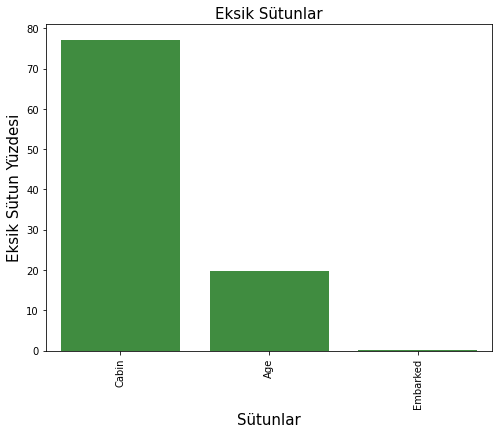

In [3]:
#eksik bilgi içeren sütunları doldurmak için tespit etmek
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Toplam', 'Yüzde'])
    ms= ms[ms["Yüzde"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Yüzde"],color="green",alpha=0.8)
    plt.xlabel('Sütunlar', fontsize=15)
    plt.ylabel('Eksik Sütun Yüzdesi', fontsize=15)
    plt.title('Eksik Sütunlar', fontsize=15)
    return ms
#eğitim veri setindeki eksik değerler olan sütunlar
tnc.columns[tnc.isna().any()]
#test veri setindeki eksik değerler olan sütunlar
tnc_test.columns[tnc_test.isna().any()]

missingdata(tnc)


In [4]:
def getName(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Bilinmiyor'
 
def replaceName(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
tnc.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def eksikSutunDoldur(tnc):    
    # Eksik değerler yerine ortalama olarak en çok kullanılanları yazdık.
    tnc['Embarked'].fillna(tnc['Embarked'].mode()[0], inplace=True)
    # Eksik yaşlara ortalama yaş
    tnc['Age'].fillna(tnc['Age'].median(), inplace=True)
    # Eksik fiyatlara ort. fiyatı yazıldı
    tnc['Fare'].fillna(tnc['Fare'].median(), inplace=True)
    
    # Yaş, Kardeş Sayısı, Ebeveyn ve Çocuk Sayısı ve Bilet Fiyat verilerini 0 ile 1 arası ölçeklendirdik.
    scaler = MinMaxScaler()
    tnc[['Age','SibSp','Parch','Fare']] = scaler.fit_transform(tnc[['Age','SibSp','Parch','Fare']])
    
    # Cinsiyetleri daha verimlilik açısından 0 ve 1 ile yazdık.
    tnc['Sex'] = tnc['Sex'].map({'female':0,'male':1}).astype(int)
    
    #One Hot Encoding(OHE): Sütunları bölüp 1,0 matrisiyle yazmak.
    
    # Class sütununa OHE uyguladık.
    tnc_class = pd.get_dummies(tnc['Pclass'],prefix='Class')
    tnc[tnc_class.columns] = tnc_class
    
    # Biniş limanına OHE uyguladık.
    tnc_emb = pd.get_dummies(tnc['Embarked'],prefix='Emb')
    tnc[tnc_emb.columns] = tnc_emb
    
    # İsimleri cinsiyetleştirdik.
    tnc['Title'] = tnc['Name'].map(lambda x: getName(x))
    tnc['Title'] = tnc.apply(replaceName, axis=1)
    # Son isimlere de OHE uyguladık.
    tnc_title = pd.get_dummies(tnc['Title'],prefix='Title')
    tnc[tnc_title.columns] = tnc_title
    
    return

In [6]:
eksikSutunDoldur(tnc)
tnc.columns #Son sütun değerlerimiz içerisinde kurtulma olasılığını etkileyebilecek sütunları belirledik.
#Modelde kullanabileceğimiz sütunlar aşağıdaki gibidir:
columns = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Class_1', 'Class_2',
       'Class_3', 'Emb_C', 'Emb_Q', 'Emb_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs']

In [7]:
# Sütunları bir numpy arrayına atadık. Bunu bir dimension olarak aldık, X
X = np.array(tnc[columns])
# Hayatta kalanları da diğer dimension olarak aldık, Y
y = np.array(tnc['Survived'])

In [8]:
network = models.Sequential()
#Bir sinir ağı oluşturuyoruz.
network.add(Dense(64, activation='relu', ))
network.add(Dropout(rate=0.2))
network.add(Dense(32, activation='relu'))
network.add(Dropout(rate=0.2))
network.add(Dense(12, activation='relu'))
network.add(Dropout(rate=0.1))
network.add(Dense(1, activation='sigmoid'))

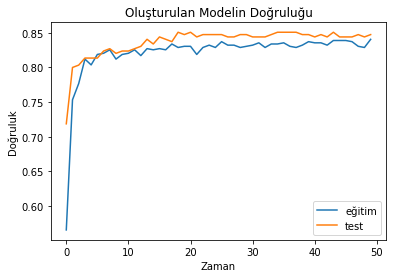

In [9]:
#Modeli Adam optimizasyon algoritmasını kullanarak derliyoruz. İkili sınıflandırma için de binary_crossentropy amaç fonksiyonunu kullanıyoruz.
network.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
 
# Geçmiş ölçümleri eğitip kaydediyoruz.
history = network.fit(X, y, epochs=50, batch_size=10, verbose=0, validation_split=0.33)
 
# Son çıktının grafiğini çizdiriyoruz.
plt.plot(history.history['accuracy'], label = 'eğitim')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.title('Oluşturulan Modelin Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Zaman')
plt.legend(loc='lower right')
plt.show()

In [10]:
eksikSutunDoldur(tnc_test)
 
X_pred = np.array(tnc_test[columns])
y_pred = network.predict(X_pred)
 
y_pred = y_pred.reshape(418)
 
# Yolcu ID ile Hayatta Kalma oranlarını birleştirdik.
tnc_subm = pd.DataFrame({'PassengerId':tnc_test['PassengerId'],'Survived':y_pred})


In [11]:
#Hatta kalma oranlarını kesin olarak tahmin için 1 ve 0'a dönüştürdük.
def binary(x):
#Hayatta kalma oranı 0.5 üzerindeyse hayatta kaldığını düşüneceğiz.
    if x >= 0.5:
        return 1
    else:
        return 0
    
# Survived sütunundaki tüm değerleri binary değere dönüştürdük.
tnc_subm['Survived'] = tnc_subm['Survived'].apply(binary)

In [12]:
time_string = time.strftime("%Y%m%d-%H%M%S")
filename = 'G171210021_G171210375_BigData' '.csv'
tnc_subm.to_csv(filename,index=False)
 
print('Sonuç Dosyası: ' + filename)

#En sonunda ID ve binary olarak kurtulanları gösteren bir csv sonuç dosyası oluşturduk.
#%82-88 arası bir sonuç aldık, elbette %100 yapanlar var ancak bunun için farklı algoritmalardan yararlanmak gerekiyor.
#G171210021 - Onur Osman Güle
#G171210375 - Fatih Enis Kaya
#Sakarya Üniversitesi Bilgisayar Mühendisliği

Sonuç Dosyası: G171210021_G171210375_BigData.csv
